In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

## define parameters

In [26]:
length = 10. #nondimensional length of window
height = 1. #window height
N = 1000 #number of vortices
gammas = 1. #vortex strength RMS (normal distribution)
rscale = 0.1 #vortex size scale (rayleigh distribution parameter)
t0 = -1.#start time for observation of convection
t1 = 1.#end time
ts = 0.001 # time step
v0 = 5 #convection speed

## set random distribution for vortex location, size and strength
origin at window center

In [43]:
vortx = np.random.uniform(low=-length/2,high=length/2,size=N)
vorty = np.random.uniform(low=-height/2,high=height/2,size=N)
vortX = np.vstack((vortx,vorty))
gamma = np.random.normal(scale=gammas,size=N)
rho = np.random.rayleigh(scale=rscale,size=N)

## set relative locations for observation
vortex window moves to the right
t=0 means observation in the center of the window

In [44]:
t = np.arange(t0,t1,ts)
obsx = -v0*t
obsy = np.zeros_like(obsx)
obsX = np.vstack((obsx,obsy))

vortex induced velocity is the minimum of $u_\theta = \frac{\Gamma}{2 \pi r}$ and $u_\theta = \frac{\Gamma r}{2\pi r_0^2}$

In [45]:
dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N

#utheta = gamma * rho * np.exp((-9*r**2) / (rho**4))          # Gaussian shape function vortex
#utheta = (0.5/np.pi)*gamma*np.minimum(1/r,r/rho)             # dim timesteps x N
# comment out one of the two following lines to get alternative vortex models:
utheta = (0.5/np.pi)*gamma/r/r
# utheta = gamma*rho**(1.5)*np.exp(-9*rho*rho*r*r)
# into cartesian coords
uind = utheta * dist[::-1] # dim 2 x timesteps x N
uind[0] *= -1 # change sign for ux (to get correct rotation)
# sum over vortices
utot = uind.sum(2) # dim 2 x timesteps

## plot time histories and psd for induced velocity

<IPython.core.display.Javascript object>


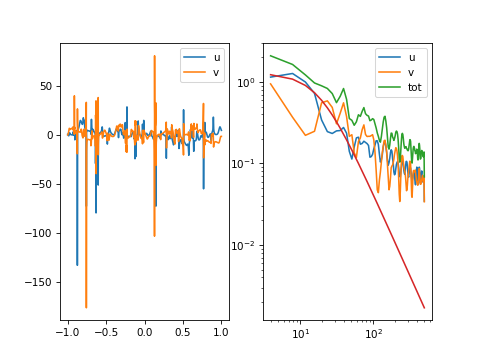

In [46]:
plt.figure(2)
plt.subplot(1,2,1)
plt.plot(t,utot[0],label='u')
plt.plot(t,utot[1],label='v')
plt.legend()
plt.subplot(1,2,2)
(valu,freq) = psd(utot[0],Fs=1/ts,detrend='mean')
(valv,freq) = psd(utot[1],Fs=1/ts,detrend='mean')
plt.loglog(freq[1:],valu[1:],label='u')
plt.loglog(freq[1:],valv[1:],label='v')
plt.loglog(freq[1:],valu[1:]+valv[1:],label='tot')
plt.legend()

## Find von Kárman spectrum that fits the Guu (E11) best and plot it.

In [47]:
def Guu(f,uu,tt):
    return 4*uu*uu*tt/(1+(2*np.pi*f*tt)**2)
from scipy import optimize
opti,_ = optimize.curve_fit(Guu,freq[1:],valu[1:]) # it is probably better to use the log of Guu and of valu here
uuopt,ttopt = opti
plt.loglog(freq[1:],Guu(freq[1:],uuopt,ttopt))